In [1]:
#Create a pyspark session;

In [3]:
from pyspark.sql import SparkSession

In [5]:
# Initialize Spark session with specified memory and cores
spark = SparkSession.builder.appName("OptimizedDataLoading").config("spark.driver.memory", "7g").config("spark.executor.memory", "7g").config("spark.driver.cores", "5").getOrCreate()

24/11/17 18:36:57 WARN Utils: Your hostname, Shwetas-Mac-mini.local resolves to a loopback address: 127.0.0.1; using 192.168.1.101 instead (on interface en1)
24/11/17 18:36:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/17 18:36:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
#Load the pre-processed data;

In [7]:
# Loading the data from a CSV file into a DataFrame
data = spark.read.csv("data", header=True, inferSchema=True)

In [8]:
data.head(1)

24/11/17 18:37:26 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Row(Start_Lat=30.265263, Start_Lng=-97.736488, Severity=0, Distance(mi)=0.07, City='Austin', State='TX', Temperature(F)=48.0, Wind_Chill(F)=45.0, Humidity(%)=58.0, Pressure(in)=29.33, Visibility(mi)=10.0, Wind_Speed(mph)=7.0, Precipitation(in)=0.0, Amenity=0, Bump=0, Crossing=1, Give_Way=0, Junction=0, No_Exit=0, Railway=0, Roundabout=0, Station=0, Stop=0, Traffic_Calming=0, Traffic_Signal=1, Turning_Loop=0, Duration_Minutes=123.22, nearest_station='000011', distance_to_station_km=1.4, traffic_volume=98, date=datetime.date(2021, 1, 1), time_of_day='Afternoon', day_of_week='Fri', is_weekend=0)]

In [9]:
#Now in K-Means we did not filter the values based on distance to the station, and we still got some interesting results.

In [10]:
#But in DBSCAN we will filter only those incidents which occured near to the station, so that we can get accurate traffic volume

In [11]:
# Set a threshold for the distance
distance_threshold = 4

In [12]:
# Filter the data to only include rows where 'distance_to_station_km' is less than the threshold
data = data.filter(data['distance_to_station_km'] <= distance_threshold)

In [13]:
print(f"Number of rows: {data.count()}")
print(f"Number of columns: {len(data.columns)}")

Number of rows: 8989849
Number of columns: 34


In [14]:
##########################################################################################################################################

In [17]:
#We will standardize the numerical columns, as there are different scales present here

In [18]:
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml import Pipeline

In [19]:
columns_to_standardize = [
    "Distance(mi)", "Temperature(F)", "Wind_Chill(F)",
    "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)",
    "Precipitation(in)", "traffic_volume", "Duration_Minutes"
]

In [20]:
# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=columns_to_standardize, outputCol="features_vector")

In [21]:
# Apply StandardScaler
scaler = StandardScaler(inputCol="features_vector", outputCol="scaled_features", withMean=True, withStd=True)

In [22]:
# Pipeline to assemble and scale the features
pipeline = Pipeline(stages=[assembler, scaler])

In [23]:
# Fit the pipeline to the data
scaler_model = pipeline.fit(data)
scaled_data = scaler_model.transform(data)

In [24]:
# Drop the columns and keep the scaled features
scaled_data = scaled_data.drop(*columns_to_standardize)

In [25]:
##########################################################################################################################################

In [26]:
#Along with the scaled features we also want to use other columns, we will add them to the 'vector'

In [27]:
additional_features = [
    "Amenity", "Bump", "Crossing", "Give_Way",
    "Junction", "No_Exit", "Railway", "Roundabout", "Station",
    "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop"
]

In [28]:
# Use VectorAssembler to combine scaled_features with additional features
assembler = VectorAssembler(
    inputCols=["scaled_features"] + additional_features,
    outputCol="combined_features"
)

In [29]:
# Transform the data
model_data = assembler.transform(scaled_data)

In [30]:
# Select only the necessary columns, excluding the original ones used for scaling
final_data = model_data.select(
    "Start_Lat", "Start_Lng", "Severity", "City", "State", "nearest_station", 
    "date", "time_of_day", "day_of_week", "is_weekend", "combined_features"
)

In [31]:
final_data.head(1)

[Row(Start_Lat=30.265263, Start_Lng=-97.736488, Severity=0, City='Austin', State='TX', nearest_station='000011', date=datetime.date(2021, 1, 1), time_of_day='Afternoon', day_of_week='Fri', is_weekend=0, combined_features=SparseVector(23, {0: -0.5369, 1: -0.8216, 2: -0.8324, 3: -0.1806, 4: -0.1331, 5: 0.3481, 6: -0.0782, 7: -0.1317, 8: -0.6466, 9: -0.041, 12: 1.0, 21: 1.0}))]

In [32]:
###########################################################################################################################################

In [33]:
# Filter dataset to only include rows where Severity = 1

In [34]:
high_severity_data = final_data.filter(final_data["Severity"] == 1)

In [35]:
#Right now we are dealing with a lot of features, PCA is the best option to reduce dimensionality and improve performance

In [36]:
from pyspark.ml.feature import PCA
import numpy as np
import matplotlib.pyplot as plt

In [37]:
# Fit the PCA model
pca = PCA(k=23, inputCol="combined_features", outputCol="pca_features")
pca_model = pca.fit(high_severity_data)

24/11/17 18:38:19 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/11/17 18:38:40 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [38]:
# Calculate the explained variance and cumulative variance from the PCA model
explained_variance = pca_model.explainedVariance.toArray()
cumulative_variance = np.cumsum(explained_variance)

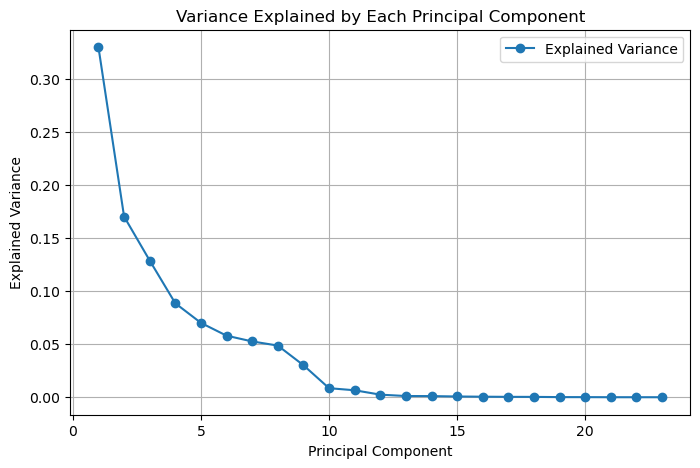

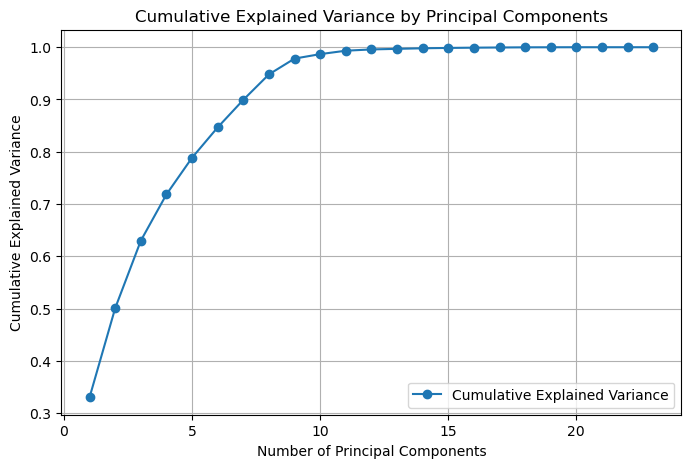

In [39]:
# Plot the explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label='Explained Variance')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.title("Variance Explained by Each Principal Component")
plt.legend()
plt.grid()
plt.show()

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label='Cumulative Explained Variance')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by Principal Components")
plt.legend()
plt.grid()
plt.show()

In [40]:
#Using cumulative variance we can go with 6-7 PC's - 7PC's - 90% cumulative variance

In [41]:
#Let's apply 7PC's to the data

In [42]:
# Applying PCA with 7 components
pca = PCA(k=7, inputCol="combined_features", outputCol="pca_features")
pca_model = pca.fit(high_severity_data)

In [43]:
# Transform the data
pca_data = pca_model.transform(high_severity_data)

In [44]:
# Remove the combined_features column from pca_data
pca_data = pca_data.drop("combined_features")

In [45]:
# Drop the Severity column from pca_data; as we have already filtered '1' to analyse high risk zones
pca_data = pca_data.drop("Severity")

In [46]:
pca_data.head(1)

[Row(Start_Lat=39.261656, Start_Lng=-103.645664, City='Limon', State='CO', nearest_station='000022', date=datetime.date(2022, 12, 24), time_of_day='Night', day_of_week='Sat', is_weekend=1, pca_features=DenseVector([0.568, -6.9498, 0.2051, -0.9736, 0.0224, 3.5873, -4.8662]))]

In [47]:
##########################################################################################################################################

In [48]:
from pyspark.ml.clustering import GaussianMixture
import matplotlib.pyplot as plt

In [49]:
#Find the optimal number of clusters;

In [98]:
# Range of k values to test
k_values = range(2, 20) 
bic_scores = []
aic_scores = []

In [102]:
# Fit the GMM model for each k and calculate BIC and AIC manually
for k in k_values:
    # Initialize and fit the GMM model
    gmm = GaussianMixture(featuresCol="pca_features", k=k)
    model = gmm.fit(pca_data)

    # Access log-likelihood from the model summary
    log_likelihood = model.summary.logLikelihood
    num_samples = pca_data.count()
    
    # Calculate the number of parameters
    # Number of parameters = k (means + covariances + weights)
    # For full covariance, number of parameters = k * (number_of_features + number_of_features * (number_of_features + 1) / 2 + 1)
    number_of_features = len(pca_data.first()["pca_features"])
    num_parameters = k * (number_of_features + number_of_features * (number_of_features + 1) / 2 + 1)
    
    # Calculate BIC and AIC
    bic = -2 * log_likelihood + num_parameters * np.log(num_samples)
    aic = -2 * log_likelihood + 2 * num_parameters

    # Append the scores to the lists
    bic_scores.append(bic)
    aic_scores.append(aic)

In [106]:
print("BIC Scores:", bic_scores)
print("AIC Scores:", aic_scores)

BIC Scores: [1616596.825663977, 1615114.402350582, 1531769.6167328237, 1506788.108287281, 1449473.282680277, 1410895.323491943, 1383768.1215543633, 1054738.3744105608, 1340375.9381306781, 1311420.5705449122, 1294867.538926779, 1178546.6301134783, 1174640.4415699218, 970983.2773033752, 988187.5713532108, 955047.5128527217, 941655.5014069239, 931678.5347190436]
AIC Scores: [1615890.5819678518, 1614055.0368063943, 1530357.1293405734, 1505022.499046968, 1447354.5515919016, 1408423.470555505, 1380943.1467698629, 1051560.2777779978, 1336844.7196500525, 1307536.230216224, 1290630.0767500282, 1173956.046088665, 1169696.735697046, 965686.4495824367, 982537.6217842097, 949044.4414356581, 935299.3081417977, 924969.219605855]


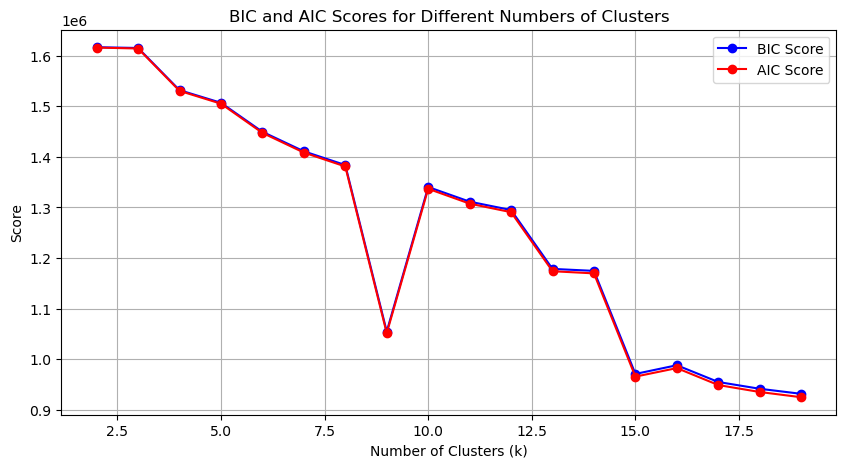

In [108]:
# Plotting the BIC and AIC scores
plt.figure(figsize=(10, 5))

# Plot BIC scores
plt.plot(k_values, bic_scores, marker='o', label='BIC Score', color='blue')
plt.plot(k_values, aic_scores, marker='o', label='AIC Score', color='red')

# Adding labels and title
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.title('BIC and AIC Scores for Different Numbers of Clusters')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [50]:
#From above we can try with 8 or 14 clusters;

In [51]:
# Initialize and fit the GMM model
gmm = GaussianMixture(featuresCol="pca_features", k=8)
model = gmm.fit(pca_data)

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=44811Kb max_used=44821Kb free=86261Kb
 bounds [0x00000001063c4000, 0x0000000108fd4000, 0x000000010e3c4000]
 total_blobs=16963 nmethods=15111 adapters=1762
 compilation: disabled (not enough contiguous free space left)


In [52]:
# Get the cluster assignments
clustered_data = model.transform(pca_data)

In [53]:
clustered_data.head(1)

[Row(Start_Lat=39.261656, Start_Lng=-103.645664, City='Limon', State='CO', nearest_station='000022', date=datetime.date(2022, 12, 24), time_of_day='Night', day_of_week='Sat', is_weekend=1, pca_features=DenseVector([0.568, -6.9498, 0.2051, -0.9736, 0.0224, 3.5873, -4.8662]), probability=DenseVector([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), prediction=0)]

In [54]:
import matplotlib.pyplot as plt

In [55]:
clustered_df = clustered_data.select("Start_Lat", "Start_Lng", "City", "State", "day_of_week", "time_of_day", "is_weekend", "prediction").toPandas()

In [56]:
k = 8  # Number of clusters

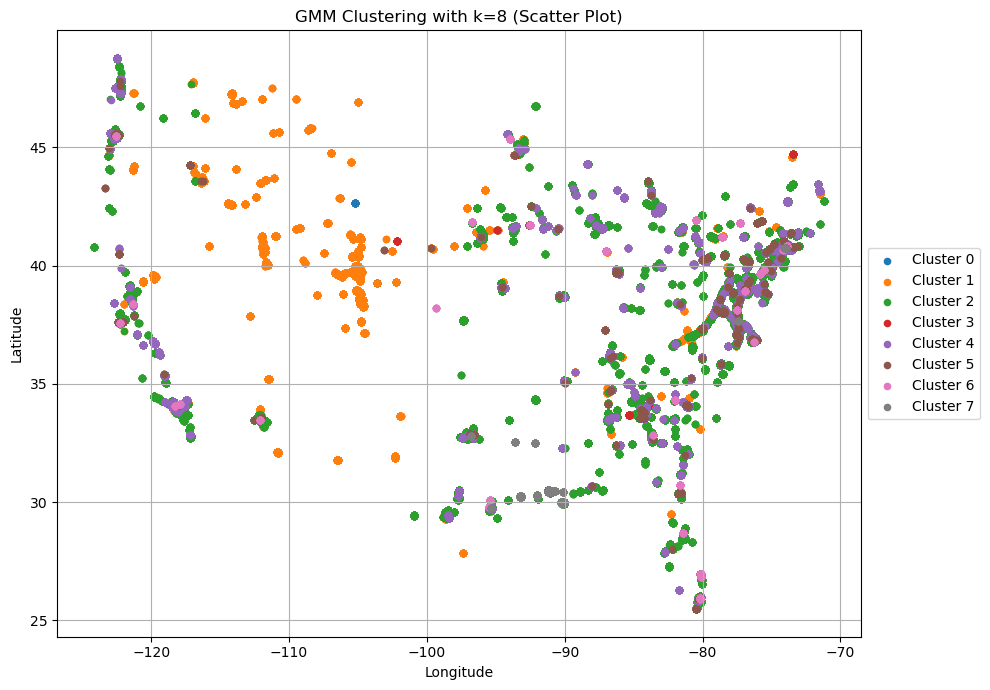

In [57]:
plt.figure(figsize=(10, 7))  

# Loop through each cluster and plot using scatter with smaller markers
for cluster in range(k):
    subset = clustered_df[clustered_df['prediction'] == cluster]
    plt.scatter(subset['Start_Lng'], subset['Start_Lat'], s=20, label=f'Cluster {cluster}')  

# Add labels, title, and grid
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GMM Clustering with k=8 (Scatter Plot)')
plt.grid(True)

# Adjust the legend to be outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.show()

In [58]:
# Save the clustered DataFrame as an Excel file
clustered_df.to_excel("clustered_data_gmm.xlsx", index=False)

In [59]:
#Saving the data as excel file, for tableau

In [60]:
#If we look at the tableau graph;

**High Concentrations: Dense clusters are present along the East Coast, West Coast (California), and around major urban centers like New York, Los Angeles, and Washington D.C.**

**Interstate Risk Zones: Clusters align with major interstate highways, indicating these as high-risk routes.**

**Sparse Midwest Clusters: Central and mountain regions show fewer clusters, except near major cities or highways.**

In [62]:
import seaborn as sns

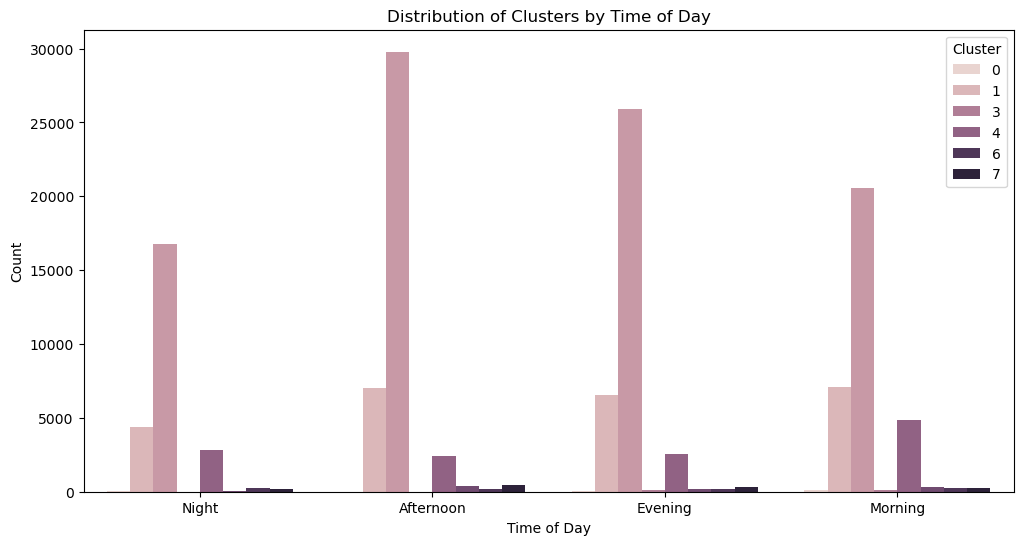

In [63]:
# Plot the distribution using a count plot
plt.figure(figsize=(12, 6))
sns.countplot(data=clustered_df, x=clustered_df["time_of_day"], hue=clustered_df["prediction"])
plt.title("Distribution of Clusters by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Count")
plt.legend(title="Cluster")
plt.show()

**Afternoon: The highest number of incidents occur, especially in Clusters 2 and 1, indicating that these periods are the most active or high-risk.**

**Night and Morning: There are fewer incidents overall, but Clusters 2 and 1 still dominate.**

**Evening: Incidents decrease compared to Afternoon but remain relatively high.**

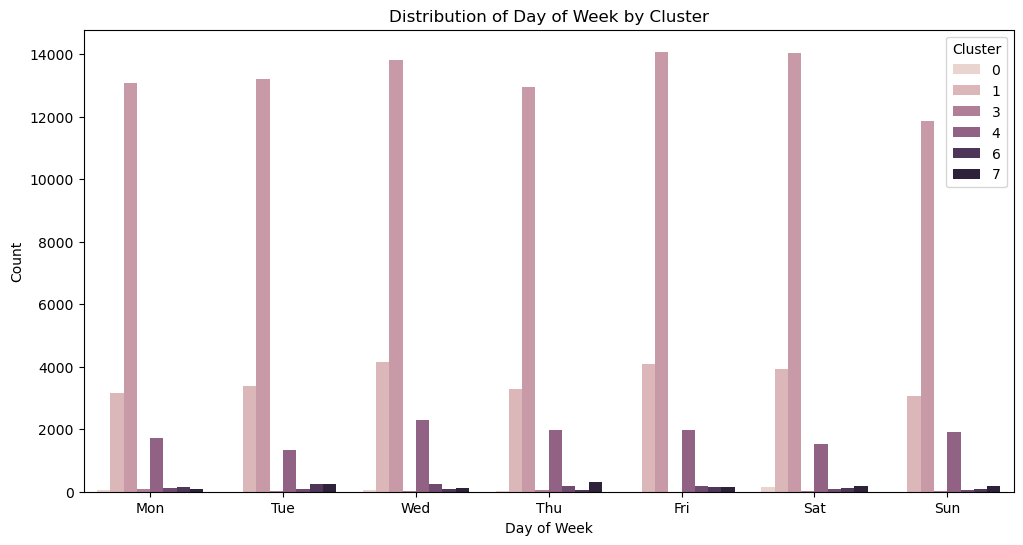

In [65]:
# Plot day_of_week distribution for each cluster
plt.figure(figsize=(12, 6))
sns.countplot(data=clustered_df, x="day_of_week", hue="prediction", 
              order=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.title("Distribution of Day of Week by Cluster")
plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.legend(title="Cluster")
plt.show()

**Clusters 0, 1 and 2: These are the most prominent clusters, with consistently high counts throughout the week. The incident counts for these clusters remain stable from Monday to Sunday.**

**Other Clusters: Clusters 3, 4, 6, and 7 have significantly lower counts compared to Clusters 2 and 1, indicating fewer incidents overall.**

In [67]:
#It is evident that clusters 0,1,2 are high in counts

In [68]:
# Filter the data to only include clusters 0, 1, and 2
filtered_data = clustered_data.filter(clustered_data['prediction'].isin([0, 1, 2]))

In [69]:
# Convert filtered_data to Pandas DataFrame
filtered_df = filtered_data.toPandas()

In [70]:
#In K-means we did not consider traffic_volume; but with traffic_volume in GMM let's find the trend!

In [71]:
colors = {0: 'blue', 1: 'orange', 2: 'red'}

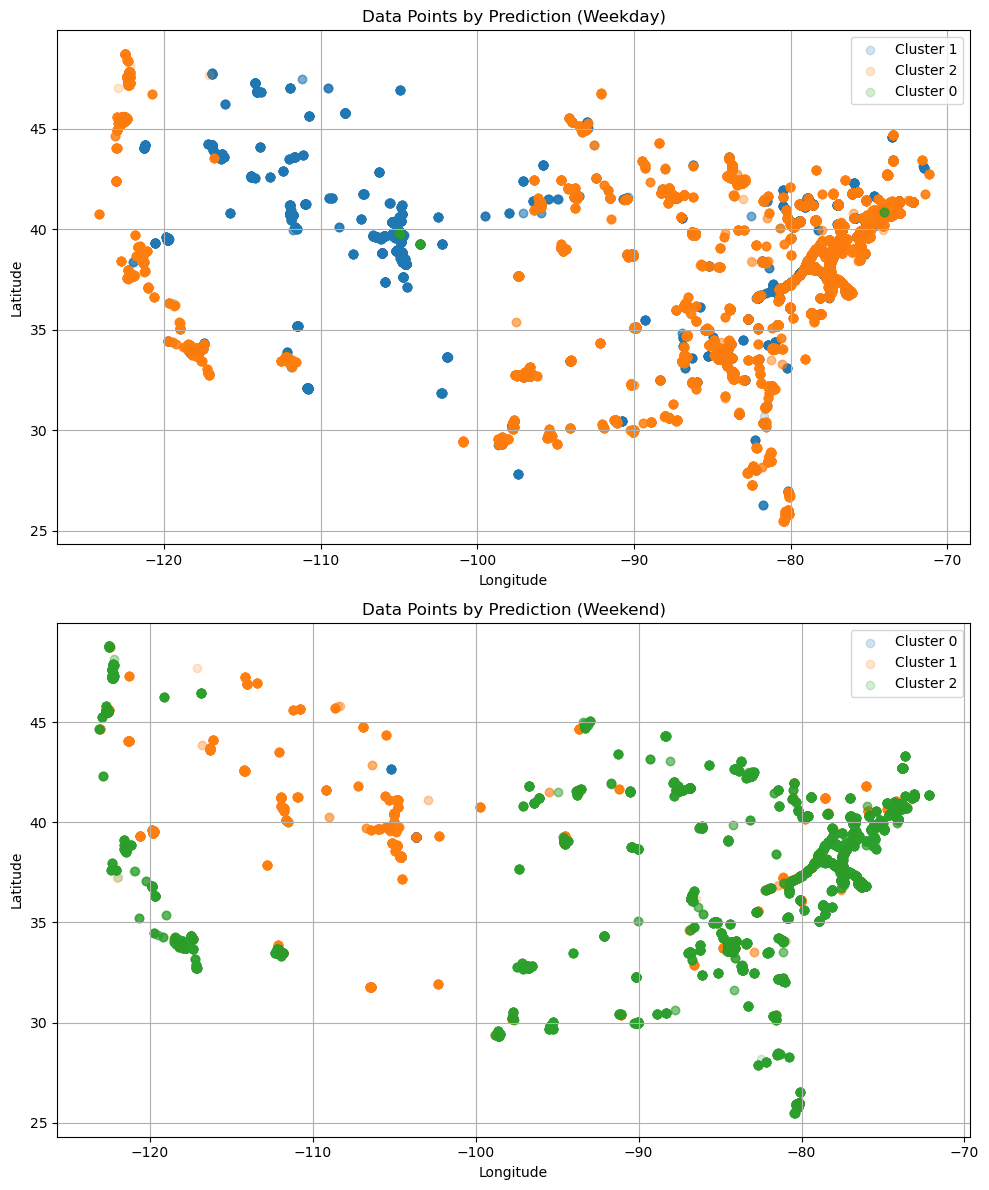

In [72]:
plt.figure(figsize=(10, 12))

# Plot for 'is_weekend' = 0 (Weekday)
plt.subplot(2, 1, 1)
for pred in filtered_df[filtered_df['is_weekend'] == 0]['prediction'].unique():
    subset = filtered_df[(filtered_df['prediction'] == pred) & (filtered_df['is_weekend'] == 0)]
    plt.scatter(subset['Start_Lng'], subset['Start_Lat'], 
                label=f'Cluster {pred}', alpha=0.2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Data Points by Prediction (Weekday)')
plt.legend()
plt.grid(True)

# Plot for 'is_weekend' = 1 (Weekend)
plt.subplot(2, 1, 2)
for pred in filtered_df[filtered_df['is_weekend'] == 1]['prediction'].unique():
    subset = filtered_df[(filtered_df['prediction'] == pred) & (filtered_df['is_weekend'] == 1)]
    plt.scatter(subset['Start_Lng'], subset['Start_Lat'], 
                label=f'Cluster {pred}', alpha=0.2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Data Points by Prediction (Weekend)')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()

**Weekday Clustering (Top Plot):**

**Clusters are more uniformly distributed across regions, suggesting varied risk patterns during the workweek.
There is a noticeable presence of all three clusters (0, 1, and 2) across different areas, indicating consistent activity.**

**Weekend Clustering (Bottom Plot):**

**Cluster 1 appears more dominant and concentrated in specific regions, suggesting increased risk or activity in those areas during weekends.
The distribution shifts compared to weekdays, indicating potential changes in traffic or event patterns over the weekend.**